In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import warnings

warnings.filterwarnings('ignore')

# Reproducibility
np.random.seed(42)

print("=" * 70)
print("ECON 5140 - HOMEWORK 1")
print("Part A: Generalized Linear Models")
print("Part B: Time Series Decomposition")
print("=" * 70)


ECON 5140 - HOMEWORK 1
Part A: Generalized Linear Models
Part B: Time Series Decomposition


## DATASET 1: Customer Purchase Behavior (GLM)
Generates synthetic customer features and a binary purchase outcome.


In [2]:
# ====================================================================
# DATASET 1: CUSTOMER PURCHASE DATA (for GLM analysis)
# ====================================================================
n_customers = 1000

# Generate customer features
age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers)  # in thousands
time_on_site = np.random.gamma(2, 3, n_customers)  # in minutes

# True relationship (latent variable)
z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n_customers)

# Generate binary outcome (Purchase: 1=Yes, 0=No)
purchase = (z > 0).astype(int)

# Create DataFrame
df_customers = pd.DataFrame({
    'Age': age,
    'Income': income,
    'TimeOnSite': time_on_site,
    'Purchase': purchase
})

print(f"Number of customers: {len(df_customers)}")
print(f"Purchase rate: {df_customers['Purchase'].mean():.2%}")
df_customers.head()


Number of customers: 1000
Purchase rate: 90.00%


,Age,Income,TimeOnSite,Purchase
0,39.967142,70.990332,2.814421,1
1,33.617357,63.869505,4.460907,1
2,41.476885,50.894456,0.667441,1
3,50.230299,40.295948,5.872412,1
4,32.658466,60.473350,8.012511,1


## DATASET 2: E-commerce Daily Sales (Time Series)
Creates 2 years of daily sales with trend, yearly + weekly seasonality, and special events.


In [3]:
# ====================================================================
# DATASET 2: E-COMMERCE SALES TIME SERIES
# ====================================================================
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)

# Components
trend = 1000 + 2*t + 0.01*t**2
yearly_seasonal = 200 * np.sin(2*np.pi*t/365) + 150 * np.cos(2*np.pi*t/365)
weekly_seasonal = 100 * np.sin(2*np.pi*t/7)

# Special events
special_events = np.zeros(n_days)
for year in [2024, 2025]:
    # Black Friday (as in the prompt)
    bf_date = pd.Timestamp(f'{year}-11-24')
    bf_idx = (dates == bf_date)
    special_events[bf_idx] = 800

    # Christmas window
    xmas_idx = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    special_events[xmas_idx] = 400

# Random noise
noise = np.random.normal(0, 50, n_days)

# Combine components
sales = trend + yearly_seasonal + weekly_seasonal + special_events + noise
sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'DayOfWeek': dates.dayofweek,
    'Month': dates.month,
    'IsWeekend': dates.dayofweek >= 5
})
df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of days: {len(df_sales)}")
df_sales['Sales'].describe()


Date range: 2024-01-01 to 2025-12-31
Number of days: 731


count     731.000000
mean     3513.075089
std      1971.539442
min      1061.751531
25%      1586.286522
50%      3307.941481
75%      4941.486536
max      8342.638282
Name: Sales, dtype: float64

# PART A: Generalized Linear Models

## A1: Exploratory Data Analysis (GLM)

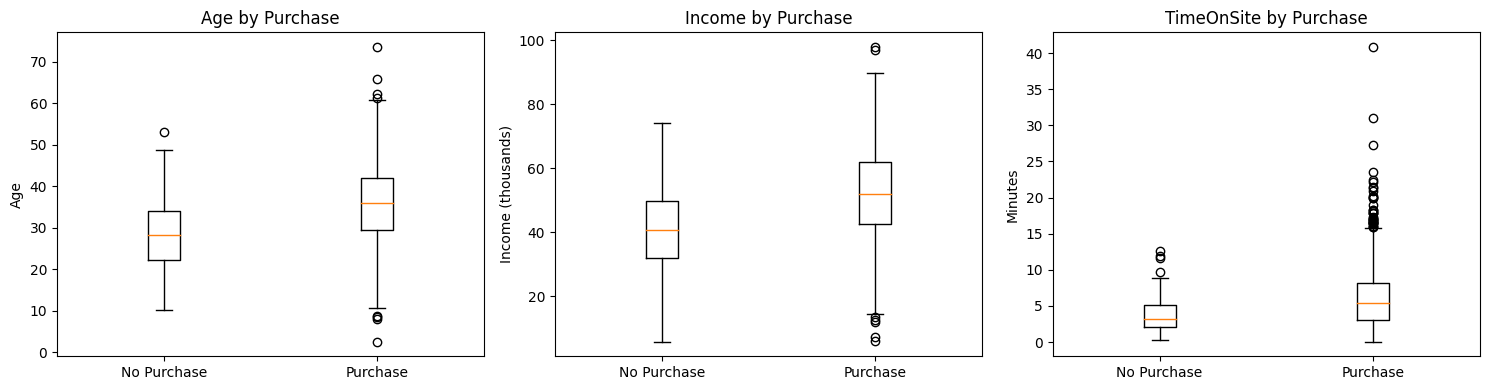

Mean values by group:


,Age,Income,TimeOnSite
No Purchase (0),28.673571,40.152509,3.925442
Purchase (1),35.917737,52.274770,6.340959


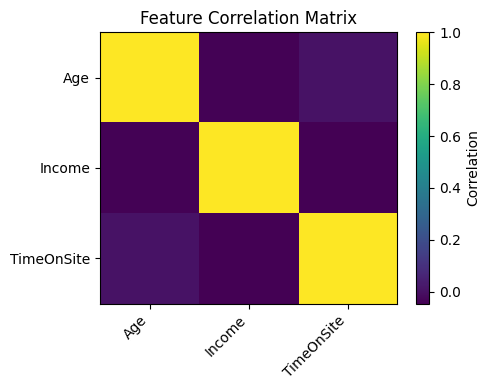

In [4]:
# Split groups
purchasers = df_customers[df_customers['Purchase'] == 1]
non_purchasers = df_customers[df_customers['Purchase'] == 0]

# 1) Box plots: Age, Income, TimeOnSite by Purchase group
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].boxplot([non_purchasers['Age'], purchasers['Age']], labels=['No Purchase', 'Purchase'])
axes[0].set_title('Age by Purchase')
axes[0].set_ylabel('Age')

axes[1].boxplot([non_purchasers['Income'], purchasers['Income']], labels=['No Purchase', 'Purchase'])
axes[1].set_title('Income by Purchase')
axes[1].set_ylabel('Income (thousands)')

axes[2].boxplot([non_purchasers['TimeOnSite'], purchasers['TimeOnSite']], labels=['No Purchase', 'Purchase'])
axes[2].set_title('TimeOnSite by Purchase')
axes[2].set_ylabel('Minutes')

plt.tight_layout()
plt.show()

# 2) Group means
group_means = df_customers.groupby('Purchase')[['Age', 'Income', 'TimeOnSite']].mean()
group_means.index = ['No Purchase (0)', 'Purchase (1)']
print("Mean values by group:")
display(group_means)

# 3) Correlation matrix heatmap (matplotlib)
corr = df_customers[['Age', 'Income', 'TimeOnSite']].corr()

plt.figure(figsize=(5, 4))
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(label='Correlation')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


## A2: Linear Probability Model (LPM)

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     55.67
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           2.86e-33
Time:                        00:21:00   Log-Likelihood:                -137.46
No. Observations:                1000   AIC:                             282.9
Df Residuals:                     996   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3104      0.047      6.556      0.0

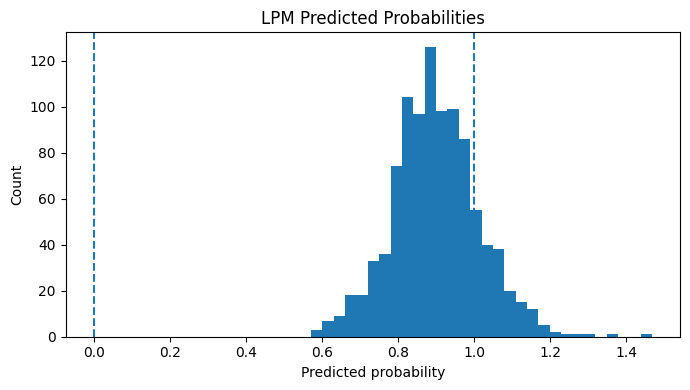

In [5]:
# 1) Fit OLS: Purchase ~ Age + Income + TimeOnSite
X = df_customers[['Age', 'Income', 'TimeOnSite']]
X = sm.add_constant(X)
y = df_customers['Purchase']

lpm = sm.OLS(y, X).fit()

# 2) Summary
print(lpm.summary())

# 3) Predicted probabilities and invalid predictions
pred_lpm = lpm.predict(X)
invalid = ((pred_lpm < 0) | (pred_lpm > 1)).sum()
pct_invalid = invalid / len(pred_lpm) * 100
print(f"Invalid predictions outside [0,1]: {invalid} ({pct_invalid:.2f}%)")

# 4) Histogram with boundaries
plt.figure(figsize=(7, 4))
plt.hist(pred_lpm, bins=30)
plt.axvline(0, linestyle='--')
plt.axvline(1, linestyle='--')
plt.title('LPM Predicted Probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## A3: Logistic Regression

                           Logit Regression Results                           
Dep. Variable:               Purchase   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Jan 2026   Pseudo R-squ.:                  0.2674
Time:                        00:21:01   Log-Likelihood:                -238.16
converged:                       True   LL-Null:                       -325.08
Covariance Type:            nonrobust   LLR p-value:                 1.874e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8737      0.715     -8.213      0.000      -7.275      -4.472
Age            0.1026      0.014      7.412      0.000       0.075       0.130
Income         0.0748      0.009      8.294      0.0

,Coefficient,OddsRatio,p_value
const,-5.873744,0.002812,2.153278e-16
Age,0.102638,1.108090,1.242226e-13
Income,0.074788,1.077656,1.098294e-16
TimeOnSite,0.269182,1.308893,2.130796e-09


Interpretation (ceteris paribus):
- Age coefficient: change in log-odds of purchase for +1 year of age.
- Income coefficient: change in log-odds of purchase for +$1k income.
- TimeOnSite coefficient: change in log-odds of purchase for +1 minute on site.
All predicted probabilities within [0,1]? True


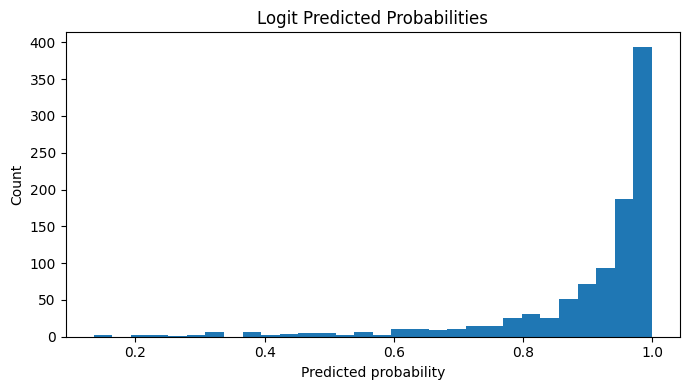

In [6]:
# 1) Fit logistic regression using statsmodels
logit_model = sm.Logit(y, X).fit(disp=False)

# 2) Summary + extract coefficients, odds ratios, p-values
print(logit_model.summary())

coefs = logit_model.params
pvals = logit_model.pvalues
odds_ratios = np.exp(coefs)

results_table = pd.DataFrame({
    'Coefficient': coefs,
    'OddsRatio': odds_ratios,
    'p_value': pvals
})
print("\nLogit coefficients, odds ratios, p-values:")
display(results_table)

# 3) Interpretation (printed)
print("Interpretation (ceteris paribus):")
print("- Age coefficient: change in log-odds of purchase for +1 year of age.")
print("- Income coefficient: change in log-odds of purchase for +$1k income.")
print("- TimeOnSite coefficient: change in log-odds of purchase for +1 minute on site.")

# 4) Predicted probabilities
pred_logit = logit_model.predict(X)
print(f"All predicted probabilities within [0,1]? {np.all((pred_logit>=0) & (pred_logit<=1))}")

plt.figure(figsize=(7, 4))
plt.hist(pred_logit, bins=30)
plt.title('Logit Predicted Probabilities')
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


## A4: Prediction for New Customers

In [7]:
# New customers (given)
new_customers = pd.DataFrame({
    'Age': [25, 35, 45, 55],
    'Income': [30, 50, 70, 90],
    'TimeOnSite': [2, 5, 8, 10]
})

# 1) Predict purchase probabilities using fitted logistic model
X_new = sm.add_constant(new_customers, has_constant='add')
new_probs = logit_model.predict(X_new)

# 2) Formatted table with classification
out = new_customers.copy()
out['PredictedProb'] = new_probs
out['Class_Purchase'] = (out['PredictedProb'] > 0.5).astype(int)

# Nice formatting
out_sorted = out.sort_values('PredictedProb', ascending=False).reset_index(drop=True)
out_sorted_display = out_sorted.copy()
out_sorted_display['PredictedProb'] = out_sorted_display['PredictedProb'].round(3)
display(out_sorted_display)
# 3) Most likely customer
best_idx = out_sorted['PredictedProb'].idxmax()
best_row = out_sorted.loc[best_idx]
print("Most likely to purchase:")
print(best_row)
print("\nReason: This customer has the highest linear index (Age, Income, and TimeOnSite) under the fitted logit model.")


,Age,Income,TimeOnSite,PredictedProb,Class_Purchase
0,55,90,10,1.000,1
1,45,70,8,0.998,1
2,35,50,5,0.943,1
3,25,30,2,0.372,0


Most likely to purchase:
Age               55.000000
Income            90.000000
TimeOnSite        10.000000
PredictedProb      0.999898
Class_Purchase     1.000000
Name: 0, dtype: float64

Reason: This customer has the highest linear index (Age, Income, and TimeOnSite) under the fitted logit model.


# PART B: Time Series Analysis

## B1: Time Series Visualization

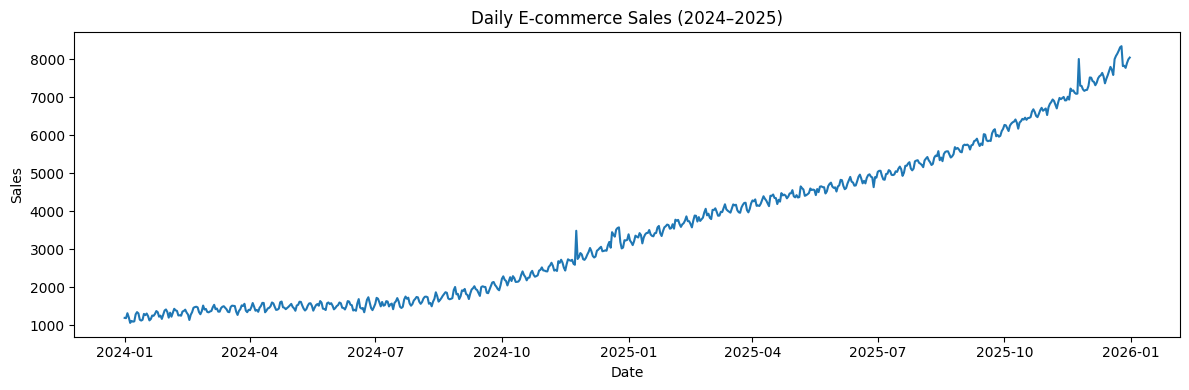

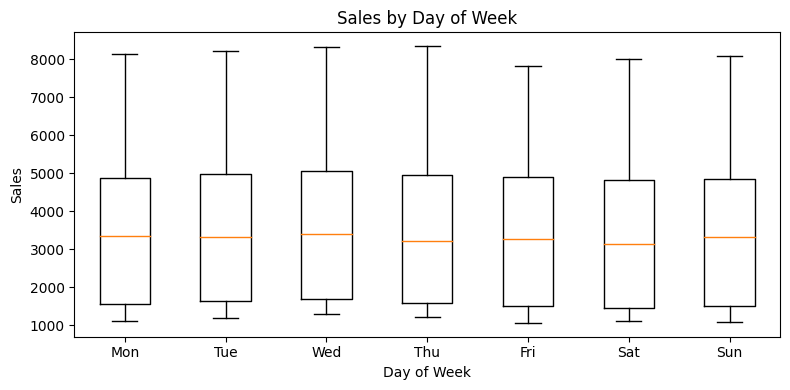

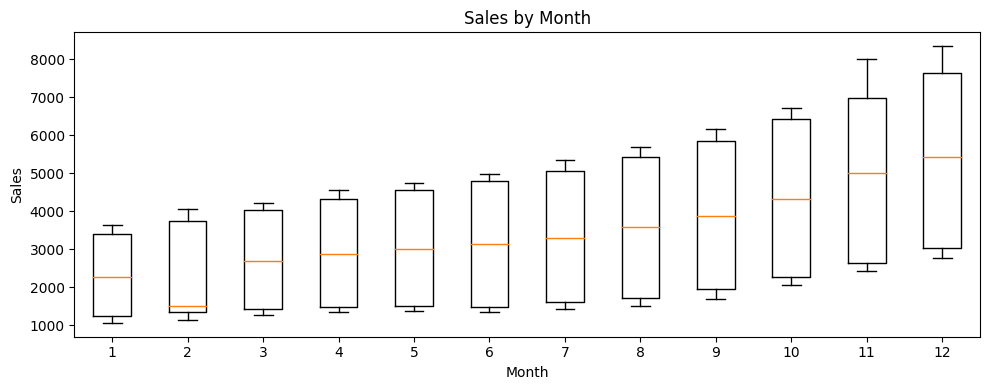

Mean sales by day of week:


,MeanSales
Mon,3519.215953
Tue,3589.052396
Wed,3627.394430
Thu,3535.594781
Fri,3453.204115
Sat,3412.415879
Sun,3452.759246


Mean sales by month:


,MeanSales
Month,
1,2318.589573
2,2534.425148
3,2732.951942
4,2901.430048
5,3027.989448
6,3144.380483
7,3342.999798
8,3581.537558
9,3908.669782


Observed patterns (based on the synthetic data generating process):
- A clear upward trend over time (quadratic trend).
- Weekly seasonality (systematic differences across days of week).
- Yearly seasonality (systematic differences across months).
- Spikes around Black Friday and elevated sales around late December.


In [8]:
# 1) Full time series plot
plt.figure(figsize=(12, 4))
plt.plot(df_sales.index, df_sales['Sales'])
plt.title('Daily E-commerce Sales (2024–2025)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# 2) Seasonal subseries via box plots
#    Sales by day of week
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sales_by_dow = [df_sales.loc[df_sales['DayOfWeek'] == i, 'Sales'] for i in range(7)]

plt.figure(figsize=(8, 4))
plt.boxplot(sales_by_dow, labels=dow_labels)
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

#    Sales by month
month_labels = [str(m) for m in range(1, 13)]
sales_by_month = [df_sales.loc[df_sales['Month'] == m, 'Sales'] for m in range(1, 13)]

plt.figure(figsize=(10, 4))
plt.boxplot(sales_by_month, labels=month_labels)
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# 3) Means
mean_by_dow = df_sales.groupby('DayOfWeek')['Sales'].mean()
mean_by_dow.index = dow_labels
mean_by_month = df_sales.groupby('Month')['Sales'].mean()

print("Mean sales by day of week:")
display(mean_by_dow.to_frame('MeanSales'))

print("Mean sales by month:")
display(mean_by_month.to_frame('MeanSales'))

# 4) Brief pattern notes (printed)
print("Observed patterns (based on the synthetic data generating process):")
print("- A clear upward trend over time (quadratic trend).")
print("- Weekly seasonality (systematic differences across days of week).")
print("- Yearly seasonality (systematic differences across months).")
print("- Spikes around Black Friday and elevated sales around late December.")


## B2: Stationarity Assessment

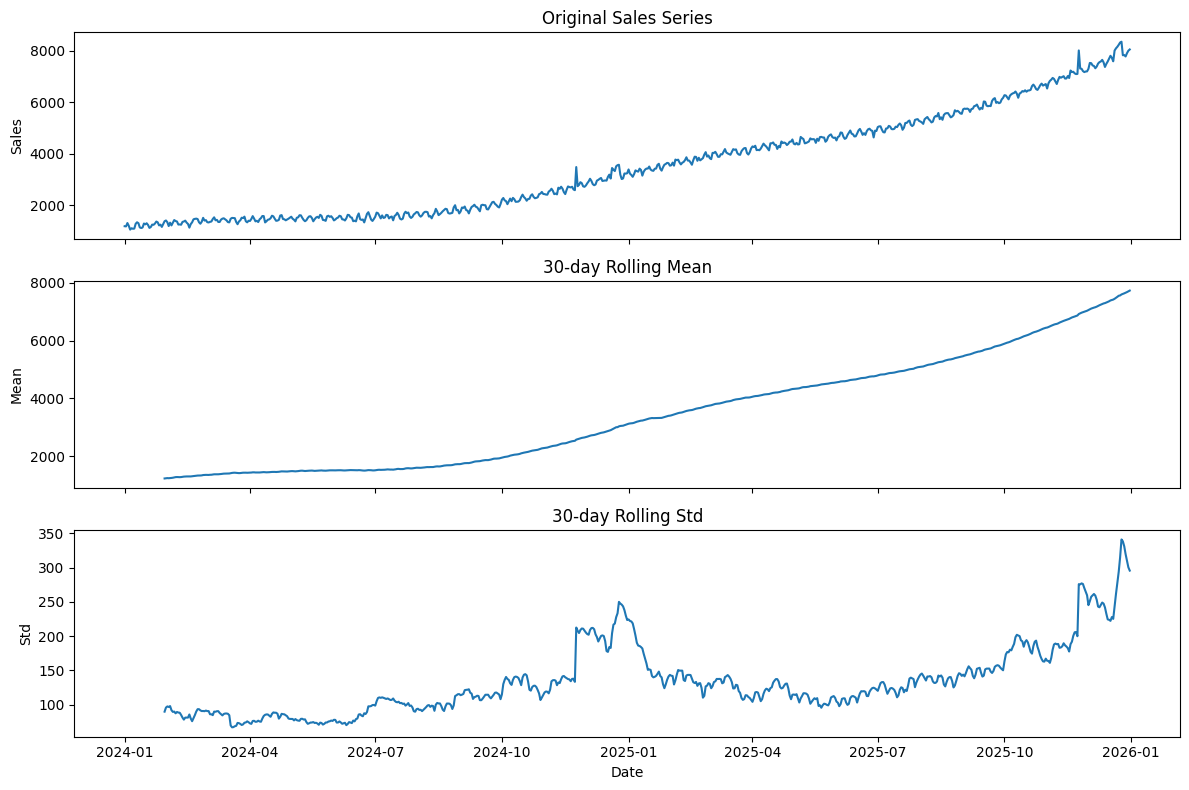

Stationarity check:
- If the rolling mean changes over time, the series is not mean-stationary.
- If the rolling standard deviation changes over time, the series is not variance-stationary.
Given the constructed upward trend and seasonality, we expect non-stationarity.


,Period,Mean,Std
0,First 6 months,1417.72,131.03
1,Last 6 months,6257.81,939.33


In [9]:
# 1) Plot original series, rolling mean and rolling std (30-day window)
roll_mean = df_sales['Sales'].rolling(window=30).mean()
roll_std = df_sales['Sales'].rolling(window=30).std()

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df_sales.index, df_sales['Sales'])
axes[0].set_title('Original Sales Series')
axes[0].set_ylabel('Sales')

axes[1].plot(df_sales.index, roll_mean)
axes[1].set_title('30-day Rolling Mean')
axes[1].set_ylabel('Mean')

axes[2].plot(df_sales.index, roll_std)
axes[2].set_title('30-day Rolling Std')
axes[2].set_ylabel('Std')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.show()

# 2) Stationarity conclusion (printed)
print("Stationarity check:")
print("- If the rolling mean changes over time, the series is not mean-stationary.")
print("- If the rolling standard deviation changes over time, the series is not variance-stationary.")
print("Given the constructed upward trend and seasonality, we expect non-stationarity.")

# 3) Compare first 6 months vs last 6 months
first_6m_end = df_sales.index[0] + pd.DateOffset(months=6)
last_6m_start = df_sales.index[-1] - pd.DateOffset(months=6)

first_6m = df_sales.loc[df_sales.index < first_6m_end, 'Sales']
last_6m = df_sales.loc[df_sales.index >= last_6m_start, 'Sales']

comparison = pd.DataFrame({
    'Period': ['First 6 months', 'Last 6 months'],
    'Mean': [first_6m.mean(), last_6m.mean()],
    'Std': [first_6m.std(), last_6m.std()]
})
comparison_display = comparison.copy()
if 'Mean' in comparison_display.columns:
    comparison_display['Mean'] = comparison_display['Mean'].round(2)
if 'Std' in comparison_display.columns:
    comparison_display['Std'] = comparison_display['Std'].round(2)
display(comparison_display)

## B3: Autocorrelation Analysis

<Figure size 1000x400 with 0 Axes>

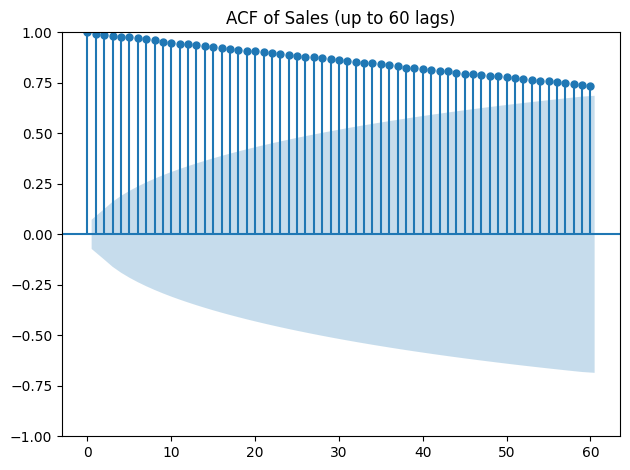

,Lag,Autocorrelation
0,1,0.998
1,7,0.998
2,30,0.996


Interpretation:
- A noticeable spike at lag 7 indicates weekly seasonality (correlation with last week).
- Large positive autocorrelation at small lags indicates persistence (today similar to yesterday).
- Longer lags can still be correlated due to trend and yearly seasonality.


In [10]:
# 1) Plot ACF up to 60 lags
plt.figure(figsize=(10, 4))
plot_acf(df_sales['Sales'], lags=60)
plt.title('ACF of Sales (up to 60 lags)')
plt.tight_layout()
plt.show()

# 2) Manual autocorrelations for specific lags
sales_arr = df_sales['Sales'].values

def autocorr_at_lag(x: np.ndarray, lag: int) -> float:
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

lags = [1, 7, 30]
ac_vals = {lag: autocorr_at_lag(sales_arr, lag) for lag in lags}
ac_table = pd.DataFrame({'Lag': list(ac_vals.keys()), 'Autocorrelation': list(ac_vals.values())})
ac_table_display = ac_table.copy()
if 'Autocorrelation' in ac_table_display.columns:
    ac_table_display['Autocorrelation'] = ac_table_display['Autocorrelation'].round(3)
display(ac_table_display)

# 3) Interpretation (printed)
print("Interpretation:")
print("- A noticeable spike at lag 7 indicates weekly seasonality (correlation with last week).")
print("- Large positive autocorrelation at small lags indicates persistence (today similar to yesterday).")
print("- Longer lags can still be correlated due to trend and yearly seasonality.")

## B4: STL Decomposition (Weekly Seasonality)

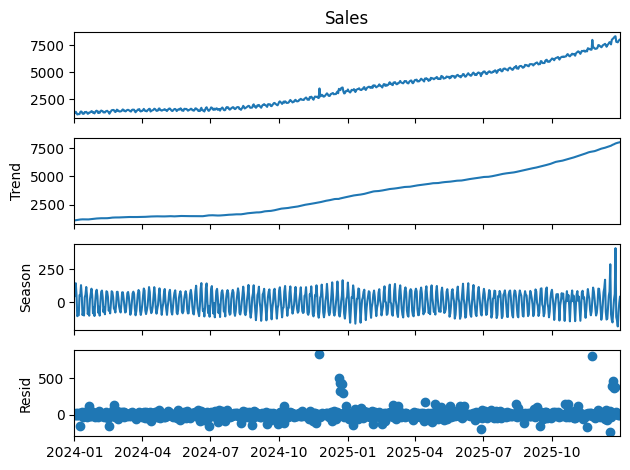

Component notes:
- Trend: should capture the long-run growth pattern.
- Seasonal: should capture the repeating weekly cycle.
- Remainder: residual variation; spikes from special events often appear here.


In [11]:
# 1) Apply STL with weekly seasonality (seasonal period ~ 7)
stl = STL(df_sales['Sales'], seasonal=7, robust=True)
res = stl.fit()

# 2) Plot components
res.plot()
plt.tight_layout()
plt.show()

# 3) Component analysis (printed)
print("Component notes:")
print("- Trend: should capture the long-run growth pattern.")
print("- Seasonal: should capture the repeating weekly cycle.")
print("- Remainder: residual variation; spikes from special events often appear here.")


## B5: Remainder Diagnostics

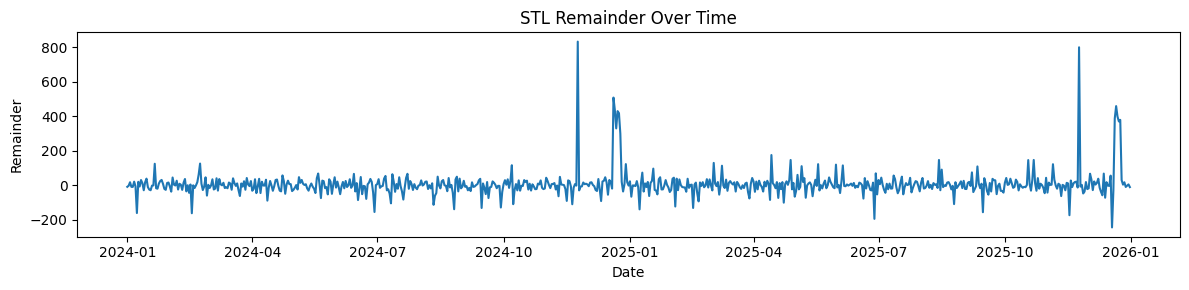

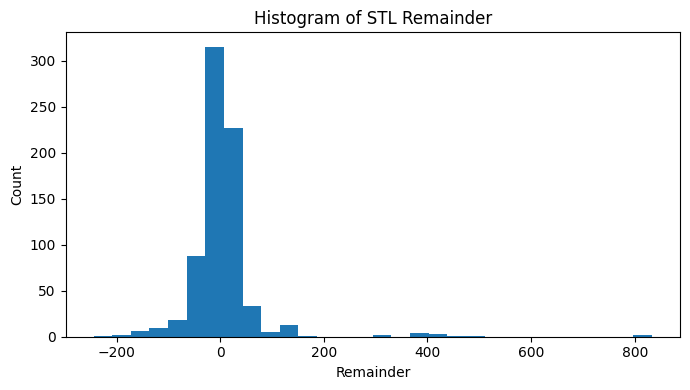

<Figure size 1000x400 with 0 Axes>

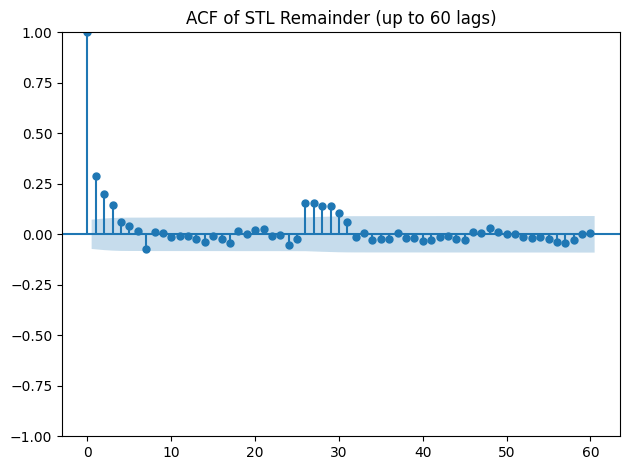

Remainder mean (should be ~0): 6.990
Remainder std: 77.398
Shapiro-Wilk normality test (sample of 500):
  statistic = 0.585, p-value = 0.0000
  (Small p-values suggest non-normality.)
Outliers where |remainder| > 3*std (threshold = 232.19): 14


,Date,Remainder
0,2024-11-24,833.37
1,2025-11-24,800.47
2,2024-12-20,508.83
3,2025-12-21,459.34
4,2024-12-21,436.74
5,2024-12-23,430.25
6,2024-12-24,418.37
7,2025-12-22,398.73
8,2025-12-20,387.86
9,2025-12-24,379.49


Black Friday outlier check:
  2024-11-24: remainder = 833.37
  2025-11-24: remainder = 800.47
Christmas window check (showing remainder means in window):
  2024-12-20 to 2024-12-25: mean remainder = 403.93, max |remainder| = 508.83
  2025-12-20 to 2025-12-25: mean remainder = 337.73, max |remainder| = 459.34


In [12]:
# 1) Extract remainder
remainder = res.resid.dropna()

# 2) Diagnostic plots
plt.figure(figsize=(12, 3))
plt.plot(remainder.index, remainder.values)
plt.title('STL Remainder Over Time')
plt.xlabel('Date')
plt.ylabel('Remainder')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.hist(remainder.values, bins=30)
plt.title('Histogram of STL Remainder')
plt.xlabel('Remainder')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plot_acf(remainder.values, lags=60)
plt.title('ACF of STL Remainder (up to 60 lags)')
plt.tight_layout()
plt.show()

# 3) Statistical summaries and normality check
rem_mean = remainder.mean()
rem_std = remainder.std()
shapiro_stat, shapiro_p = stats.shapiro(remainder.sample(500, random_state=42))  # sample for speed

print(f"Remainder mean (should be ~0): {rem_mean:.3f}")
print(f"Remainder std: {rem_std:.3f}")
print("Shapiro-Wilk normality test (sample of 500):")
print(f"  statistic = {shapiro_stat:.3f}, p-value = {shapiro_p:.4f}")
print("  (Small p-values suggest non-normality.)")

# 4) Identify outliers: |remainder| > 3*std
threshold = 3 * rem_std
outliers = remainder[np.abs(remainder) > threshold].sort_values(key=np.abs, ascending=False)

print(f"Outliers where |remainder| > 3*std (threshold = {threshold:.2f}): {len(outliers)}")
outlier_table = pd.DataFrame({
    'Date': outliers.index,
    'Remainder': outliers.values
}).reset_index(drop=True)

outlier_table_display = outlier_table.copy()
if 'Remainder' in outlier_table_display.columns:
    outlier_table_display['Remainder'] = outlier_table_display['Remainder'].round(2)
display(outlier_table_display)

# Investigate whether Black Friday and Christmas are visible among outliers
bf_dates = [pd.Timestamp('2024-11-24'), pd.Timestamp('2025-11-24')]
xmas_windows = [
    (pd.Timestamp('2024-12-20'), pd.Timestamp('2024-12-25')),
    (pd.Timestamp('2025-12-20'), pd.Timestamp('2025-12-25'))
]

print("Black Friday outlier check:")
for d in bf_dates:
    if d in remainder.index:
        print(f"  {d.date()}: remainder = {remainder.loc[d]:.2f}")
    else:
        print(f"  {d.date()}: not in index")

print("Christmas window check (showing remainder means in window):")
for start, end in xmas_windows:
    window = remainder.loc[(remainder.index >= start) & (remainder.index <= end)]
    if len(window) > 0:
        print(f"  {start.date()} to {end.date()}: mean remainder = {window.mean():.2f}, max |remainder| = {np.max(np.abs(window.values)):.2f}")